Model :

In [1]:
import math
import cv2
import dlib
import time
from collections import Counter
import pandas as pd
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split
import seaborn as sns

import data_process


class ModelKNN:
    def __init__(self, train_x, train_y):
        self.training_x = train_x
        self.training_t = train_y
        self.emotion_data = self.initial_data()

    def initial_data(self):
        data = {'pixels': [], 'emotion': ''}
        t = pd.DataFrame(data=data)
        return t

    def detect_face(self, img_path):
        detector = dlib.get_frontal_face_detector()
        predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
        emotions = ['anger', 'contempt', 'happy', 'sadness']
        faceDet = cv2.CascadeClassifier("haarcascade\haarcascade_frontalface_default.xml")
        if img_path == 'video':
            cap = cv2.VideoCapture(0)
            while True:
                k = cv2.waitKey(1)
                ret, img = cap.read()
                # img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
                # img = cv2.flip(img, 1)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                faces = faceDet.detectMultiScale(
                    gray,
                    scaleFactor=1.1,
                    minNeighbors=5,
                    minSize=(20, 20)
                )
                for (x, y, w, h) in faces:
                    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
                    gray = gray[y:y + h, x:x + w]
                    # get_landmarks(img)

                cv2.imshow('video', img)

                if k == 32:
                    try:
                        gray = cv2.resize(gray, (350, 350))
                        print(self.predict(gray, 5))
                    except:
                        print('error')
                if k == 27:
                    break
            cap.release()
            cv2.destroyAllWindows()
            return 'close'

        else:
                frame = cv2.imread(img_path)

                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

                face = faceDet.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5),
                                                flags=cv2.CASCADE_SCALE_IMAGE)
                if len(face) == 1:
                    facefeatures = face
                else:
                    facefeatures = ""

                for (x, y, w, h) in facefeatures:
                    if facefeatures == "":
                        print("no face found in file: %s" % img_path)
                    else:
                        gray = gray[y:y + h, x:x + w]

                detections = detector(gray, 1)
                for k, d in enumerate(detections):
                    shape = predictor(gray, d)
                    for i in range(1, 68):
                        cv2.circle(gray, (shape.part(i).x, shape.part(i).y), 1, (0, 0, 255), thickness=1)
                gray = cv2.resize(gray, (48, 48))
                cv2.imwrite(img_path, gray)


    def train(self, t_data, label):
        for f, b in zip(t_data, label):
            try:
                self.emotion_data.loc[-1] = [f, b]
                self.emotion_data.index = self.emotion_data.index + 1
                self.emotion_data = self.emotion_data.sort_index()
            except:
                print('error in "' + b)

    def euclidean_distance(self, row1, row2):
        distance_x = 0.0
        distance_x += (row1 - row2)**2
        return sum(sum(sum(np.sqrt(distance_x))))


    def predict(self, face, k):
        distance_d = {'distance': [], 'emotion': ''}
        df = pd.DataFrame(data=distance_d)
        for i, r in self.emotion_data.iterrows():
            distance = self.euclidean_distance(self.emotion_data.iloc[i]['pixels'], face)
            df.loc[-1] = [distance, self.emotion_data.iloc[i]['emotion']]
            df.index = df.index + 1
            df = df.sort_index()
        df2 = df.sort_values(by=['distance'], ascending=True, axis=0)[:k]
        counter = Counter(df2['emotion'])
        prediction = counter.most_common()[0][0]
        return prediction


    def test(self, p_data, label):
        correct = 0
        incorrect = 0
        for f, b in zip(p_data, label):
            predict_face = self.predict(f, 5)
            if b == predict_face:
                correct += 1
            else:
                incorrect += 1
        accuracy = (1 / (correct + incorrect)) * correct
        print('correct: ' + str(correct) + '\n' + 'incorrect: ' + str(incorrect) + '\n' + 'accuracy: ' + str(accuracy))

get training data and test data from dataset 1:

In [2]:
x,y = data_process.process_data('dataset.csv', "KNN")
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

create model and train it with training data, test it afterwards.

In [3]:
model_1 = ModelKNN(X_train, y_train)
model_1.train(X_train, y_train)
model_1.test(X_test,y_test)

correct: 64
incorrect: 32
accuracy: 0.6666666666666666


do the same with data from dataset 2

In [4]:
x2,y2 = data_process.process_data('dataset2.csv', "KNN")
X_train2, X_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2, random_state=42)

train and test it again

In [5]:

model_2 = ModelKNN(X_train2, y_train2)
model_2.train(X_train2, y_train2)
model_2.test(X_test2,y_test2)



correct: 66
incorrect: 30
accuracy: 0.6875


metrics for both models

In [11]:
from sklearn.metrics import precision_recall_fscore_support as score, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import seaborn as sns

metrics = list()
cm = dict()

y_pred = list()
y_pred2 = list()
for a in X_test:
    y_pred.append(model_1.predict(a,7))

for a in X_test2:
      y_pred2.append(model_2.predict(a,7))


In [12]:
from sklearn.preprocessing import LabelEncoder, label_binarize

enc = LabelEncoder()
y_test = enc.fit_transform(y_test)
y_pred = enc.fit_transform(y_pred)

y_test2 = enc.fit_transform(y_test2)
y_pred2 = enc.fit_transform(y_pred2)

precision, recall, fscore, _ = score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2]),
        label_binarize(y_pred, classes=[0,1,2]),
        average='weighted', multi_class='ovr')
metrics.append(pd.Series({'precision':precision, 'recall':recall, 'fscore':fscore, 'accuracy':accuracy, 'AUC':auc}, name="model1"))
cm = confusion_matrix(y_test,y_pred)

metrics2 = list()
cm2 = dict()

precision2, recall2, fscore2, _ = score(y_test2, y_pred2, average='weighted')
accuracy2 = accuracy_score(y_test2, y_pred2)
auc2 = roc_auc_score(label_binarize(y_test2, classes=[0,1,2]),
        label_binarize(y_pred2, classes=[0,1,2]),
        average='weighted', multi_class='ovr')
metrics2.append(pd.Series({'precision':precision2, 'recall':recall2, 'fscore':fscore2, 'accuracy':accuracy2,'AUC':auc2}, name="model2"))
cm2 = confusion_matrix(y_test2,y_pred2)
m = metrics + metrics2
metrics = pd.concat(m, axis=1)

metrics

,model1,model2
precision,0.721136,0.722555
recall,0.718750,0.708333
fscore,0.718418,0.695483
accuracy,0.718750,0.708333
AUC,0.815595,0.842747


[2, 0, 3, 1]


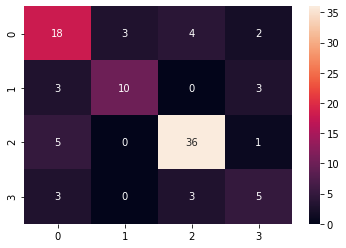

In [13]:
def get_unique_N(iterable):
    seen = set()
    for e in iterable:
        if e in seen:
            continue
        seen.add(e)
        yield e

k = get_unique_N(y_test)
print(list(k))

%matplotlib inline

ax = sns.heatmap(cm, annot=True, fmt='d')



[2, 0, 3, 1]


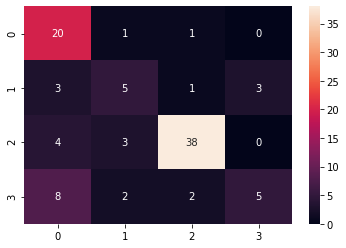

In [14]:
k2= get_unique_N(y_test2)
print(list(k2))

ax2 = sns.heatmap(cm2, annot=True, fmt='d')

TypeError: estimator should be an estimator implementing 'fit' method, <__main__.ModelKNN object at 0x000001FB31D5B070> was passed